### Artificial Intelligence Engineer Nanodegree - Probabilistic Models
## Project: Sign Language Recognition System
- [Introduction](#intro)
- [Part 1 Feature Selection](#part1_tutorial)
    - [Tutorial](#part1_tutorial)
    - [Features Submission](#part1_submission)
    - [Features Unittest](#part1_test)
- [Part 2 Train the models](#part2_tutorial)
    - [Tutorial](#part2_tutorial)
    - [Model Selection Score Submission](#part2_submission)
    - [Model Score Unittest](#part2_test)
- [Part 3 Build a Recognizer](#part3_tutorial)
    - [Tutorial](#part3_tutorial)
    - [Recognizer Submission](#part3_submission)
    - [Recognizer Unittest](#part3_test)
- [Part 4 (OPTIONAL) Improve the WER with Language Models](#part4_info)

<a id='intro'></a>
## Introduction
The overall goal of this project is to build a word recognizer for American Sign Language video sequences, demonstrating the power of probabalistic models.  In particular, this project employs  [hidden Markov models (HMM's)](https://en.wikipedia.org/wiki/Hidden_Markov_model) to analyze a series of measurements taken from videos of American Sign Language (ASL) collected for research (see the [RWTH-BOSTON-104 Database](http://www-i6.informatik.rwth-aachen.de/~dreuw/database-rwth-boston-104.php)).  In this video, the right-hand x and y locations are plotted as the speaker signs the sentence.
[![ASLR demo](http://www-i6.informatik.rwth-aachen.de/~dreuw/images/demosample.png)](https://drive.google.com/open?id=0B_5qGuFe-wbhUXRuVnNZVnMtam8)

The raw data, train, and test sets are pre-defined.  You will derive a variety of feature sets (explored in Part 1), as well as implement three different model selection criterion to determine the optimal number of hidden states for each word model (explored in Part 2). Finally, in Part 3 you will implement the recognizer and compare the effects the different combinations of feature sets and model selection criteria.  

At the end of each Part, complete the submission cells with implementations, answer all questions, and pass the unit tests.  Then submit the completed notebook for review!

<a id='part1_tutorial'></a>
## PART 1: Data

### Features Tutorial
##### Load the initial database
A data handler designed for this database is provided in the student codebase as the `AslDb` class in the `asl_data` module.  This handler creates the initial [pandas](http://pandas.pydata.org/pandas-docs/stable/) dataframe from the corpus of data included in the `data` directory as well as dictionaries suitable for extracting data in a format friendly to the [hmmlearn](https://hmmlearn.readthedocs.io/en/latest/) library.  We'll use those to create models in Part 2.

To start, let's set up the initial database and select an example set of features for the training set.  At the end of Part 1, you will create additional feature sets for experimentation. 

In [1]:
import numpy as np
import pandas as pd
from asl_data import AslDb


asl = AslDb() # initializes the database
asl.df.head() # displays the first five rows of the asl database, indexed by video and frame

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker
video frame                                                           
98    0         149     181      170      175     161      62  woman-1
      1         149     181      170      175     161      62  woman-1
      2         149     181      170      175     161      62  woman-1
      3         149     181      170      175     161      62  woman-1
      4         149     181      170      175     161      62  woman-1

In [2]:
asl.df.ix[98,1]  # look at the data available for an individual frame

/home/runix/Instalers/anaconda/anaconda3/envs/datascience_py3/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """Entry point for launching an IPython kernel.


left-x         149
left-y         181
right-x        170
right-y        175
nose-x         161
nose-y          62
speaker    woman-1
Name: (98, 1), dtype: object

The frame represented by video 98, frame 1 is shown here:
![Video 98](http://www-i6.informatik.rwth-aachen.de/~dreuw/database/rwth-boston-104/overview/images/orig/098-start.jpg)

##### Feature selection for training the model
The objective of feature selection when training a model is to choose the most relevant variables while keeping the model as simple as possible, thus reducing training time.  We can use the raw features already provided or derive our own and add columns to the pandas dataframe `asl.df` for selection. As an example, in the next cell a feature named `'grnd-ry'` is added. This feature is the difference between the right-hand y value and the nose y value, which serves as the "ground" right y value. 

In [3]:
asl.df['grnd-ry'] = asl.df['right-y'] - asl.df['nose-y']
asl.df.head()  # the new feature 'grnd-ry' is now in the frames dictionary

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  
video frame           
98    0          113  
      1          113  
      2          113  
      3          113  
      4          113

##### Try it!

In [4]:
from asl_utils import test_features_tryit

asl.df['grnd-rx'] = asl.df['right-x'] - asl.df['nose-x']
asl.df['grnd-ly'] = asl.df['left-y'] - asl.df['nose-y']
asl.df['grnd-lx'] = asl.df['left-x'] - asl.df['nose-x']

# test the code
test_features_tryit(asl)

asl.df sample


left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  
video frame                                      
98    0          113        9      119      -12  
      1          113        9      119      -12  
      2          113        9      119      -12  
      3          113        9      119      -12  
      4          113        9      119      -12

In [5]:
# collect the features into a list
features_ground = ['grnd-rx','grnd-ry','grnd-lx','grnd-ly']
 #show a single set of features for a given (video, frame) tuple
[asl.df.ix[98,1][v] for v in features_ground]

[9, 113, -12, 119]

##### Build the training set
Now that we have a feature list defined, we can pass that list to the `build_training` method to collect the features for all the words in the training set.  Each word in the training set has multiple examples from various videos.  Below we can see the unique words that have been loaded into the training set:

In [6]:
training = asl.build_training(features_ground)
print("Training words: {}".format(training.words))

Training words: ['READ', 'WHAT', 'BROCCOLI', 'BREAK-DOWN', 'IX-1P', 'VISIT', 'LOVE', 'CAR', 'BOY', 'BROTHER', 'ARRIVE', 'CHICKEN', 'HERE', 'CHICAGO', 'BOX', 'SAY-1P', 'TOY', 'NOT', 'PUTASIDE', 'FIND', 'BILL', 'LAST-WEEK', 'APPLE', 'GIVE', 'MAN', 'VEGETABLE', 'POTATO', 'BUY', 'WHO', 'TEACHER', 'YESTERDAY', 'NAME', 'HAVE', 'WILL', 'GIVE1', 'LIVE', 'BOOK', 'TOY1', 'HOMEWORK', 'LEG', 'POSS', 'SHOOT', 'IX', 'FISH', 'CORN', 'CAN', 'CANDY', 'HIT', 'OLD', 'SAY', 'TELL', 'NEXT-WEEK', 'BUT', 'GIRL', 'THROW', 'BORROW', 'CHOCOLATE', 'FUTURE1', 'MOTHER', 'MARY', 'BUY1', 'MOVIE', 'KNOW', 'ANN', 'NEW-YORK', 'MANY', 'LIKE', 'SELL', 'DECIDE', 'SEARCH-FOR', 'PREFER', 'WRITE', 'PARTY', 'WANT', 'SEE', 'GO1', 'FRED', 'FRIEND', 'GET', 'LEAVE', 'TOMORROW', 'CHINA', 'THINK', 'NEW', 'FRANK', 'VIDEOTAPE', 'SOMETHING-ONE', 'JOHN', 'SELF', 'BLUE', 'CORN1', 'STOLEN', 'EAT', 'PEOPLE', 'FUTURE', 'GIVE2', 'PAST', 'JANA', 'SUE', 'STUDENT', 'GO2', 'WONT', 'GIVE3', 'FINISH', 'BLAME', 'ALL', 'SHOULD', 'COAT', 'GROUP', 'G

The training data in `training` is an object of class `WordsData` defined in the `asl_data` module.  in addition to the `words` list, data can be accessed with the `get_all_sequences`, `get_all_Xlengths`, `get_word_sequences`, and `get_word_Xlengths` methods. We need the `get_word_Xlengths` method to train multiple sequences with the `hmmlearn` library.  In the following example, notice that there are two lists; the first is a concatenation of all the sequences(the X portion) and the second is a list of the sequence lengths(the Lengths portion).

In [7]:
training.get_word_Xlengths('CHOCOLATE')

(array([[-11,  48,   7, 120],
        [-11,  48,   8, 109],
        [ -8,  49,  11,  98],
        [ -7,  50,   7,  87],
        [ -4,  54,   7,  77],
        [ -4,  54,   6,  69],
        [ -4,  54,   6,  69],
        [-13,  52,   6,  69],
        [-13,  52,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [ -8,  51,   6,  69],
        [-10,  59,   7,  71],
        [-15,  64,   9,  77],
        [-17,  75,  13,  81],
        [ -4,  48,  -4, 113],
        [ -2,  53,  -4, 113],
        [ -4,  55,   2,  98],
        [ -4,  58,   2,  98],
        [ -1,  59,   2,  89],
        [ -1,  59,  -1,  84],
        [ -1,  59,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,  -1,  84],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ -7,  63,   3,  83],
        [ 

###### More feature sets
So far we have a simple feature set that is enough to get started modeling.  However, we might get better results if we manipulate the raw values a bit more, so we will go ahead and set up some other options now for experimentation later.  For example, we could normalize each speaker's range of motion with grouped statistics using [Pandas stats](http://pandas.pydata.org/pandas-docs/stable/api.html#api-dataframe-stats) functions and [pandas groupby](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html).  Below is an example for finding the means of all speaker subgroups.

In [8]:
df_means = asl.df.groupby('speaker').mean()
df_means

,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx
speaker,,,,,,,,,,
man-1,206.248203,218.679449,155.464350,150.371031,175.031756,61.642600,88.728430,-19.567406,157.036848,31.216447
woman-1,164.661438,161.271242,151.017865,117.332462,162.655120,57.245098,60.087364,-11.637255,104.026144,2.006318
woman-2,183.214509,176.527232,156.866295,119.835714,170.318973,58.022098,61.813616,-13.452679,118.505134,12.895536


To select a mean that matches by speaker, use the pandas [map](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.map.html) method:

In [9]:
asl.df['left-x-mean']= asl.df['speaker'].map(df_means['left-x'])
asl.df.head()

left-x  left-y  right-x  right-y  nose-x  nose-y  speaker  \
video frame                                                              
98    0         149     181      170      175     161      62  woman-1   
      1         149     181      170      175     161      62  woman-1   
      2         149     181      170      175     161      62  woman-1   
      3         149     181      170      175     161      62  woman-1   
      4         149     181      170      175     161      62  woman-1   

             grnd-ry  grnd-rx  grnd-ly  grnd-lx  left-x-mean  
video frame                                                   
98    0          113        9      119      -12   164.661438  
      1          113        9      119      -12   164.661438  
      2          113        9      119      -12   164.661438  
      3          113        9      119      -12   164.661438  
      4          113        9      119      -12   164.661438

##### Try it!

In [10]:
from asl_utils import test_std_tryit

df_std = asl.df.groupby('speaker').std()

# test the code
test_std_tryit(df_std)

df_std


,left-x,left-y,right-x,right-y,nose-x,nose-y,grnd-ry,grnd-rx,grnd-ly,grnd-lx,left-x-mean
speaker,,,,,,,,,,,
man-1,15.154425,36.328485,18.901917,54.902340,6.654573,5.520045,53.487999,20.269032,36.572749,15.080360,0.0
woman-1,17.573442,26.594521,16.459943,34.667787,3.549392,3.538330,33.972660,16.764706,27.117393,17.328941,0.0
woman-2,15.388711,28.825025,14.890288,39.649111,4.099760,3.416167,39.128572,16.191324,29.320655,15.050938,0.0


<a id='part1_submission'></a>
### Features Implementation Submission
Implement four feature sets and answer the question that follows.
- normalized Cartesian coordinates
    - use *mean* and *standard deviation* statistics and the [standard score](https://en.wikipedia.org/wiki/Standard_score) equation to account for speakers with different heights and arm length
    
- polar coordinates
    - calculate polar coordinates with [Cartesian to polar equations](https://en.wikipedia.org/wiki/Polar_coordinate_system#Converting_between_polar_and_Cartesian_coordinates)
    - use the [np.arctan2](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.arctan2.html) function and *swap the x and y axes* to move the $0$ to $2\pi$ discontinuity to 12 o'clock instead of 3 o'clock;  in other words, the normal break in radians value from $0$ to $2\pi$ occurs directly to the left of the speaker's nose, which may be in the signing area and interfere with results.  By swapping the x and y axes, that discontinuity move to directly above the speaker's head, an area not generally used in signing.

- delta difference
    - as described in Thad's lecture, use the difference in values between one frame and the next frames as features
    - pandas [diff method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.diff.html) and [fillna method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.fillna.html) will be helpful for this one

- custom features
    - These are your own design; combine techniques used above or come up with something else entirely. We look forward to seeing what you come up with! 
    Some ideas to get you started:
        - normalize using a [feature scaling equation](https://en.wikipedia.org/wiki/Feature_scaling)
        - normalize the polar coordinates
        - adding additional deltas


In [11]:
def normalise_feature(df, features, new_names, mean, std):
    for feature, new_name in zip(features, new_names):
        asl.df[new_name] = (df[feature].values \
                    - mean.loc[df['speaker']][feature].values) / std.loc[df['speaker']][feature].values
    
normalise_feature(asl.df, ['left-x', 'left-y', 'right-x', 'right-y'], 
                          ['norm-lx', 'norm-ly', 'norm-rx', 'norm-ry'], 
                          df_means, df_std)

features_norm = ['norm-rx', 'norm-ry', 'norm-lx','norm-ly']

In [12]:
def x(p):
    return p+"-y"

def y(p):
    return p+"-x"

def calculate_polar_coordinates(df, p1, p2, radius_name, tetha_name):
    a = df[y(p1)] - df[y(p2)]
    b = df[x(p1)] - df[x(p2)]
    
    df[radius_name] = np.hypot(a, b)
    df[tetha_name] = np.arctan2(a, b)
    
calculate_polar_coordinates(asl.df, 'left', 'nose', 'polar-lr', 'polar-ltheta')
calculate_polar_coordinates(asl.df, 'right', 'nose', 'polar-rr', 'polar-rtheta')

features_polar = ['polar-rr', 'polar-rtheta', 'polar-lr', 'polar-ltheta']

In [13]:
def calculate_delta(df, feature, new_name):
    df[new_name] = df[feature].diff().fillna(0)
    
calculate_delta(asl.df, ['left-x', 'left-y', 'right-x', 'right-y'], 
                        ['delta-lx', 'delta-ly', 'delta-rx', 'delta-ry'])

features_delta = ['delta-rx', 'delta-ry', 'delta-lx', 'delta-ly']

In [14]:
def normalise(df, feature_name):
    df[feature_name] = df.groupby(['speaker'])[feature_name].transform(lambda x: ((x - x.mean()) / x.std()))
    
def two_values_diff(df, p1, p2, new_name):
    df[new_name] = (df[p1] - df[p2]).abs()
    normalise(df, new_name)
    
def calculate_triangle_area(df, p1, p2, p3, new_name):
    xa, xb, xc = df[x(p1)], df[x(p2)], df[x(p3)]
    ya, yb, yc = df[y(p1)], df[y(p2)], df[y(p3)]
    
    df[new_name] = 0.5 * ((xa - xc) * (yb - ya) - (xa - xb) * (yc - ya)).abs()
    normalise(df, new_name)
    
                   
calculate_polar_coordinates(asl.df, 'left', 'right', 'diff_r', 'diff_theta')
calculate_delta(asl.df, ['diff_r', 'diff_theta'], ['delta_r', 'delta_theta'])

two_values_diff(asl.df, 'left-x', 'right-x', 'hands_x_dist')
calculate_delta(asl.df, ['hands_x_dist'], ['delta_hands_x_dist'])

calculate_triangle_area(asl.df, 'left', 'right', 'nose', 'hands_nose_area')
calculate_delta(asl.df, ['hands_nose_area'], ['hands_nose_area_delta'])
                      
features_custom = ['diff_theta', 'polar-rtheta', 'polar-ltheta', 'hands_nose_area_delta']
features_custom_2 = ['diff_theta', 'polar-rtheta', 'polar-ltheta', 'diff_r', 'polar-lr']

**Question 1:**  What custom features did you choose for the features_custom set and why?

**Answer 1:**

We have created two different sets of features, being both of them based on the fact that the location of the nose, left hand and right hand form a triangle, so they only change the way in which the triangle is represented.

In the first feature set the orientation is given by the three angles that define the triangle and the magnitude is given by the area of the triangle. In the second one the magnitude is represented by two distances; the distance between the hands and the distance between the left hand and the nose. (The decision of choosing the left hand instead of the right hand is not based in empirical observations and it has been choosen randomly)

<a id='part1_test'></a>
### Features Unit Testing
Run the following unit tests as a sanity check on the defined "ground", "norm", "polar", and 'delta"
feature sets.  The test simply looks for some valid values but is not exhaustive.  However, the project should not be submitted if these tests don't pass.

In [15]:
import unittest

class TestFeatures(unittest.TestCase):

    def test_features_ground(self):
        sample = (asl.df.ix[98, 1][features_ground]).tolist()
        self.assertEqual(sample, [9, 113, -12, 119])

    def test_features_norm(self):
        sample = (asl.df.ix[98, 1][features_norm]).tolist()
        np.testing.assert_almost_equal(sample, [ 1.153,  1.663, -0.891,  0.742], 3)

    def test_features_polar(self):
        sample = (asl.df.ix[98,1][features_polar]).tolist()
        np.testing.assert_almost_equal(sample, [113.3578, 0.0794, 119.603, -0.1005], 3)

    def test_features_delta(self):
        sample = (asl.df.ix[98, 0][features_delta]).tolist()
        self.assertEqual(sample, [0, 0, 0, 0])
        sample = (asl.df.ix[98, 18][features_delta]).tolist()
        self.assertTrue(sample in [[-16, -5, -2, 4], [-14, -9, 0, 0]], "Sample value found was {}".format(sample))
                         
suite = unittest.TestLoader().loadTestsFromModule(TestFeatures())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 0.011s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part2_tutorial'></a>
## PART 2: Model Selection
### Model Selection Tutorial
The objective of Model Selection is to tune the number of states for each word HMM prior to testing on unseen data.  In this section you will explore three methods: 
- Log likelihood using cross-validation folds (CV)
- Bayesian Information Criterion (BIC)
- Discriminative Information Criterion (DIC) 

##### Train a single word
Now that we have built a training set with sequence data, we can "train" models for each word.  As a simple starting example, we train a single word using Gaussian hidden Markov models (HMM).   By using the `fit` method during training, the [Baum-Welch Expectation-Maximization](https://en.wikipedia.org/wiki/Baum%E2%80%93Welch_algorithm) (EM) algorithm is invoked iteratively to find the best estimate for the model *for the number of hidden states specified* from a group of sample seequences. For this example, we *assume* the correct number of hidden states is 3, but that is just a guess.  How do we know what the "best" number of states for training is?  We will need to find some model selection technique to choose the best parameter.

In [16]:
import warnings
from hmmlearn.hmm import GaussianHMM

def train_a_word(word, num_hidden_states, features):
    
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    training = asl.build_training(features)  
    X, lengths = training.get_word_Xlengths(word)
    model = GaussianHMM(n_components=num_hidden_states, n_iter=1000).fit(X, lengths)
    logL = model.score(X, lengths)
    return model, logL

demoword = 'BOOK'
model, logL = train_a_word(demoword, 3, features_ground)
print("Number of states trained in model for {} is {}".format(demoword, model.n_components))
print("logL = {}".format(logL))

Number of states trained in model for BOOK is 3
logL = -2331.1138127433205


The HMM model has been trained and information can be pulled from the model, including means and variances for each feature and hidden state.  The [log likelihood](http://math.stackexchange.com/questions/892832/why-we-consider-log-likelihood-instead-of-likelihood-in-gaussian-distribution) for any individual sample or group of samples can also be calculated with the `score` method.

In [17]:
def show_model_stats(word, model):
    print("Number of states trained in model for {} is {}".format(word, model.n_components))    
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])    
    for i in range(model.n_components):  # for each hidden state
        print("hidden state #{}".format(i))
        print("mean = ", model.means_[i])
        print("variance = ", variance[i])
        print()
    
show_model_stats(demoword, model)

Number of states trained in model for BOOK is 3
hidden state #0
mean =  [ -3.46504869  50.66686933  14.02391587  52.04731066]
variance =  [ 49.12346305  43.04799144  39.35109609  47.24195772]

hidden state #1
mean =  [ -11.45300909   94.109178     19.03512475  102.2030162 ]
variance =  [  77.403668    203.35441965   26.68898447  156.12444034]

hidden state #2
mean =  [ -1.12415027  69.44164191  17.02866283  77.7231196 ]
variance =  [ 19.70434594  16.83041492  30.51552305  11.03678246]



##### Try it!
Experiment by changing the feature set, word, and/or num_hidden_states values in the next cell to see changes in values.  

In [18]:
my_testword = 'CHOCOLATE'
model, logL = train_a_word(my_testword, 3, features_ground) # Experiment here with different parameters
show_model_stats(my_testword, model)
print("logL = {}".format(logL))

Number of states trained in model for CHOCOLATE is 3
hidden state #0
mean =  [ -9.30211403  55.32333876   6.92259936  71.24057775]
variance =  [ 16.16920957  46.50917372   3.81388185  15.79446427]

hidden state #1
mean =  [   0.58333333   87.91666667   12.75        108.5       ]
variance =  [  39.41055556   18.74388889    9.855       144.4175    ]

hidden state #2
mean =  [ -5.40587658  60.1652424    2.32479599  91.3095432 ]
variance =  [   7.95073876   64.13103127   13.68077479  129.5912395 ]

logL = -601.3291470028636


##### Visualize the hidden states
We can plot the means and variances for each state and feature.  Try varying the number of states trained for the HMM model and examine the variances.  Are there some models that are "better" than others?  How can you tell?  We would like to hear what you think in the classroom online.

In [19]:
%matplotlib inline

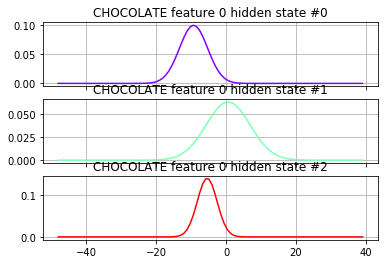

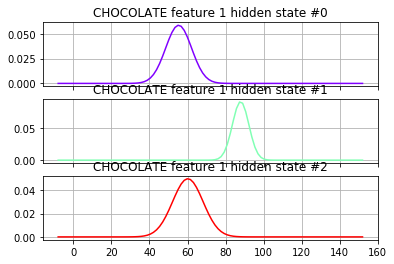

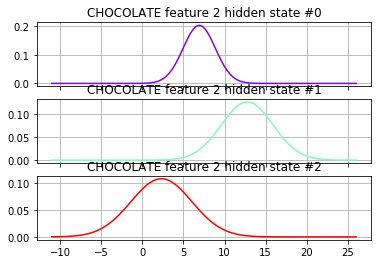

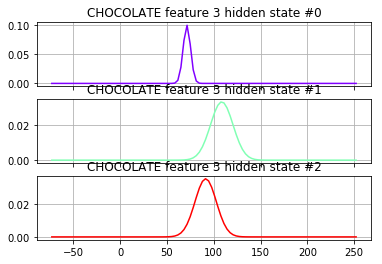

In [20]:
import math
from matplotlib import (cm, pyplot as plt, mlab)

def visualize(word, model):
    """ visualize the input model for a particular word """
    variance=np.array([np.diag(model.covars_[i]) for i in range(model.n_components)])
    figures = []
    for parm_idx in range(len(model.means_[0])):
        xmin = int(min(model.means_[:,parm_idx]) - max(variance[:,parm_idx]))
        xmax = int(max(model.means_[:,parm_idx]) + max(variance[:,parm_idx]))
        fig, axs = plt.subplots(model.n_components, sharex=True, sharey=False)
        colours = cm.rainbow(np.linspace(0, 1, model.n_components))
        for i, (ax, colour) in enumerate(zip(axs, colours)):
            x = np.linspace(xmin, xmax, 100)
            mu = model.means_[i,parm_idx]
            sigma = math.sqrt(np.diag(model.covars_[i])[parm_idx])
            ax.plot(x, mlab.normpdf(x, mu, sigma), c=colour)
            ax.set_title("{} feature {} hidden state #{}".format(word, parm_idx, i))

            ax.grid(True)
        figures.append(plt)
    for p in figures:
        p.show()
        
visualize(my_testword, model)

#####  ModelSelector class
Review the `ModelSelector` class from the codebase found in the `my_model_selectors.py` module.  It is designed to be a strategy pattern for choosing different model selectors.  For the project submission in this section, subclass `SelectorModel` to implement the following model selectors.  In other words, you will write your own classes/functions in the `my_model_selectors.py` module and run them from this notebook:

- `SelectorCV `:  Log likelihood with CV
- `SelectorBIC`: BIC 
- `SelectorDIC`: DIC

You will train each word in the training set with a range of values for the number of hidden states, and then score these alternatives with the model selector, choosing the "best" according to each strategy. The simple case of training with a constant value for `n_components` can be called using the provided `SelectorConstant` subclass as follow:

In [21]:
from my_model_selectors import SelectorConstant

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
word = 'VEGETABLE' # Experiment here with different words
model = SelectorConstant(training.get_all_sequences(), training.get_all_Xlengths(), word, n_constant=3).select()
print("Number of states trained in model for {} is {}".format(word, model.n_components))

Number of states trained in model for VEGETABLE is 3


##### Cross-validation folds
If we simply score the model with the Log Likelihood calculated from the feature sequences it has been trained on, we should expect that more complex models will have higher likelihoods. However, that doesn't tell us which would have a better likelihood score on unseen data.  The model will likely be overfit as complexity is added.  To estimate which topology model is better using only the training data, we can compare scores using cross-validation.  One technique for cross-validation is to break the training set into "folds" and rotate which fold is left out of training.  The "left out" fold scored.  This gives us a proxy method of finding the best model to use on "unseen data". In the following example, a set of word sequences is broken into three folds using the [scikit-learn Kfold](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) class object. When you implement `SelectorCV`, you will use this technique.

In [22]:
from sklearn.model_selection import KFold

training = asl.build_training(features_ground) # Experiment here with different feature sets
word = 'VEGETABLE' # Experiment here with different words
word_sequences = training.get_word_sequences(word)
split_method = KFold()
for cv_train_idx, cv_test_idx in split_method.split(word_sequences):
    print("Train fold indices:{} Test fold indices:{}".format(cv_train_idx, cv_test_idx))  # view indices of the folds

Train fold indices:[2 3 4 5] Test fold indices:[0 1]
Train fold indices:[0 1 4 5] Test fold indices:[2 3]
Train fold indices:[0 1 2 3] Test fold indices:[4 5]


**Tip:** In order to run `hmmlearn` training using the X,lengths tuples on the new folds, subsets must be combined based on the indices given for the folds.  A helper utility has been provided in the `asl_utils` module named `combine_sequences` for this purpose.

##### Scoring models with other criterion
Scoring model topologies with **BIC** balances fit and complexity within the training set for each word.  In the BIC equation, a penalty term penalizes complexity to avoid overfitting, so that it is not necessary to also use cross-validation in the selection process.  There are a number of references on the internet for this criterion.  These [slides](http://www2.imm.dtu.dk/courses/02433/doc/ch6_slides.pdf) include a formula you may find helpful for your implementation.

The advantages of scoring model topologies with **DIC** over BIC are presented by Alain Biem in this [reference](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.58.6208&rep=rep1&type=pdf) (also found [here](https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf)).  DIC scores the discriminant ability of a training set for one word against competing words.  Instead of a penalty term for complexity, it provides a penalty if model liklihoods for non-matching words are too similar to model likelihoods for the correct word in the word set.

<a id='part2_submission'></a>
### Model Selection Implementation Submission
Implement `SelectorCV`, `SelectorBIC`, and `SelectorDIC` classes in the `my_model_selectors.py` module.  Run the selectors on the following five words. Then answer the questions about your results.

**Tip:** The `hmmlearn` library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

In [23]:
words_to_train = ['FISH', 'BOOK', 'VEGETABLE', 'FUTURE', 'JOHN']
import timeit

In [24]:
from my_model_selectors import SelectorCV

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorCV(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 5 states with time 0.6047933680001734 seconds
Training complete for BOOK with 15 states with time 6.862274271999922 seconds
Training complete for VEGETABLE with 15 states with time 2.3206119269998453 seconds
Training complete for FUTURE with 15 states with time 7.458372819000033 seconds
Training complete for JOHN with 15 states with time 65.48636610199992 seconds


In [25]:
from my_model_selectors import SelectorBIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorBIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 6 states with time 0.28459164000014425 seconds
Training complete for BOOK with 15 states with time 1.7533868359996632 seconds
Training complete for VEGETABLE with 15 states with time 0.6032449730000735 seconds
Training complete for FUTURE with 15 states with time 2.0118215490001603 seconds
Training complete for JOHN with 15 states with time 16.65015592800046 seconds


In [26]:
from my_model_selectors import SelectorDIC

training = asl.build_training(features_ground)  # Experiment here with different feature sets defined in part 1
sequences = training.get_all_sequences()
Xlengths = training.get_all_Xlengths()
for word in words_to_train:
    start = timeit.default_timer()
    model = SelectorDIC(sequences, Xlengths, word, 
                    min_n_components=2, max_n_components=15, random_state = 14).select()
    end = timeit.default_timer()-start
    if model is not None:
        print("Training complete for {} with {} states with time {} seconds".format(word, model.n_components, end))
    else:
        print("Training failed for {}".format(word))

Training complete for FISH with 2 states with time 0.2866688799995245 seconds
Training complete for BOOK with 15 states with time 1.756271762000324 seconds
Training complete for VEGETABLE with 15 states with time 0.5938337059997139 seconds
Training complete for FUTURE with 15 states with time 1.8931928849997348 seconds
Training complete for JOHN with 15 states with time 16.53012332400067 seconds


**Question 2:**  Compare and contrast the possible advantages and disadvantages of the various model selectors implemented.

**Answer 2:**

__CV Selector__

The advantages of the CV Selector is that it is less sensitive to the random split between test and train set. Furthermore, the model is eventually trained on every sample. In other words, by doing different splits and training on the whole dataset, we reduce the possibility that the split was made in such a way  that data distribution is different between both sets.

The main drawback is that KFold is computationally expensive, as it has to train and test more models. (Altough this processes can be parallelized because they do not have dependencies among them)

__BIC Selector__

BIC Selector is a trade-off between likelihood and model complexity (is measured by number of parameters). Basically, the idea behind the bic selector es penalizing the model complexity in order to avoid overfitting.

The main disadvantages of the BIC Selector is that it focus in statistics whithin the given the class without taking in account the other classes, so BIC selector may not be appropiate for classification problems [1]

__DIC__

DIC Selector is more appropiate for classification regression than BIC Selector as it takes into account the other classes and as a result it performs better. On the other hand, DIC models are more complex and require more parameters. [1]

For example, this is the comparison between BIC and DIC selectors in [1].


| Criterion Rec.        | Rate           | States  | Parameters |
| --------------------- |:--------------:|:-------:|-----------:|
| BIC                   | 93.97          | 87      | 1692       |
| DIC                   | 95.08          | 101     | 4299       |


DIC criterion uses 2.5 times more parameters than BIC but it performs 1 % better than the BIC criterion.


[1] https://pdfs.semanticscholar.org/ed3d/7c4a5f607201f3848d4c02dd9ba17c791fc2.pdf


<a id='part2_test'></a>
### Model Selector Unit Testing
Run the following unit tests as a sanity check on the implemented model selectors.  The test simply looks for valid interfaces  but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [27]:
from asl_test_model_selectors import TestSelectors
suite = unittest.TestLoader().loadTestsFromModule(TestSelectors())
unittest.TextTestRunner().run(suite)

....
----------------------------------------------------------------------
Ran 4 tests in 75.876s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

<a id='part3_tutorial'></a>
## PART 3: Recognizer
The objective of this section is to "put it all together".  Using the four feature sets created and the three model selectors, you will experiment with the models and present your results.  Instead of training only five specific words as in the previous section, train the entire set with a feature set and model selector strategy.  
### Recognizer Tutorial
##### Train the full training set
The following example trains the entire set with the example `features_ground` and `SelectorConstant` features and model selector.  Use this pattern for you experimentation and final submission cells.



In [28]:
# autoreload for automatically reloading changes made in my_model_selectors and my_recognizer
%load_ext autoreload
%autoreload 2

from my_model_selectors import SelectorConstant

def train_all_words(features, model_selector):
    training = asl.build_training(features)  # Experiment here with different feature sets defined in part 1
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()
    model_dict = {}
    for word in training.words:
        model = model_selector(sequences, Xlengths, word, 
                        n_constant=3).select()
        model_dict[word]=model
    return model_dict

models = train_all_words(features_ground, SelectorConstant)
print("Number of word models returned = {}".format(len(models)))

Number of word models returned = 112


##### Load the test set
The `build_test` method in `ASLdb` is similar to the `build_training` method already presented, but there are a few differences:
- the object is type `SinglesData` 
- the internal dictionary keys are the index of the test word rather than the word itself
- the getter methods are `get_all_sequences`, `get_all_Xlengths`, `get_item_sequences` and `get_item_Xlengths`

In [29]:
test_set = asl.build_test(features_ground)
print("Number of test set items: {}".format(test_set.num_items))
print("Number of test set sentences: {}".format(len(test_set.sentences_index)))

Number of test set items: 178
Number of test set sentences: 40


<a id='part3_submission'></a>
### Recognizer Implementation Submission
For the final project submission, students must implement a recognizer following guidance in the `my_recognizer.py` module.  Experiment with the four feature sets and the three model selection methods (that's 12 possible combinations). You can add and remove cells for experimentation or run the recognizers locally in some other way during your experiments, but retain the results for your discussion.  For submission, you will provide code cells of **only three** interesting combinations for your discussion (see questions below). At least one of these should produce a word error rate of less than 60%, i.e. WER < 0.60 . 

**Tip:** The hmmlearn library may not be able to train or score all models.  Implement try/except contructs as necessary to eliminate non-viable models from consideration.

First, we import the libraries we are going to need through this section

In [30]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from concurrent.futures import ThreadPoolExecutor
import itertools

from my_model_selectors import SelectorConstant, SelectorDIC, SelectorBIC, SelectorCV
from my_recognizer import recognize
import time

import seaborn as sns
from matplotlib import (cm, pyplot as plt, mlab)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
 def hmm_scorer(test_set, guesses):
    """
        Function that compute the score of a guesses with respect to the ground thruth.
    """
    S = 0
    N = len(test_set.wordlist)
    num_test_words = len(test_set.wordlist)
    if len(guesses) != num_test_words:
        print("Size of guesses must equal number of test words ({})!".format(num_test_words))
        
    for word_id in range(num_test_words):
        if guesses[word_id] != test_set.wordlist[word_id]:
            S += 1
            
    wer = float(S) / float(N)
    
    return wer
    
    
def hmm_runner(dataset, selector_def, evaluator=hmm_scorer):
    """
        Create and train the model using the given dataset and selector, then compute the goodness of
        the model and return some statistics about the model.
    """
    start = time.time()
    
    features_name, (training, test_set) = dataset
    selector_name, selector = selector_def
    
    sequences = training.get_all_sequences()
    Xlengths = training.get_all_Xlengths()

    model_dict = {word: selector(sequences, Xlengths, word, n_constant=3).select()
                     for word in training.words}

    probabilities, guesses = recognize(model_dict, test_set)
    score = evaluator(test_set, guesses)
    
    return {
        'model' : model_dict,
        'score' : score,
        'test_set' : test_set,
        'recognize_probabilities' : probabilities,
        'recognize_guesses' : guesses,
        'epleased_time' : (time.time() - start),
        'features_name': features_name,
        'selector_name': selector_name
    }


def get_dataset(features):
    """
        Get the training and test dataset using the given features.
    """
    return asl.build_training(features), asl.build_test(features)


selectors = [('SelectorContant', SelectorConstant), 
             ('SelectorDIC', SelectorDIC), 
             ('SelectorBIC', SelectorBIC), 
             ('SelectorCV', SelectorCV)]

datasets = [('Features_norm', get_dataset(features_norm)), 
            ('Features_polar', get_dataset(features_polar)), 
            ('Features_delta', get_dataset(features_delta)),
            ('Features_custom', get_dataset(features_custom)),
            ('Features_custom_2', get_dataset(features_custom_2))]

# Create an array with all the available combinations of datasets and selectors
model_combinations = list(itertools.product(datasets, selectors))

In [32]:
# Run the models in parallel using a threadpoolexecutor. The number of thread to use by the
# executor can be specified as follows: ThreadPoolExecutor(x) where x is the number of threads we want.

with ThreadPoolExecutor() as e:
    dataset_stream, selector_stream = zip(*model_combinations)
    results = list(e.map(hmm_runner, dataset_stream, selector_stream))
    
result_df = pd.DataFrame(results)

Model results

In [33]:
result_df[['features_name', 'selector_name','score', 'epleased_time']]\
        .sort_values(['score'], ascending=True).reset_index()

,index,features_name,selector_name,score,epleased_time
0,19,Features_custom_2,SelectorCV,0.471910,1941.716930
1,17,Features_custom_2,SelectorDIC,0.488764,1093.649357
2,18,Features_custom_2,SelectorBIC,0.511236,1081.698802
3,14,Features_custom,SelectorBIC,0.511236,1204.432578
4,13,Features_custom,SelectorDIC,0.511236,1200.890226
5,5,Features_polar,SelectorDIC,0.522472,1155.185466
6,7,Features_polar,SelectorCV,0.528090,2011.366364
7,6,Features_polar,SelectorBIC,0.550562,1149.751419
8,15,Features_custom,SelectorCV,0.556180,2041.162810
9,16,Features_custom_2,SelectorContant,0.584270,182.215171


Score achieved by each of the combinations (selector, feature_set)

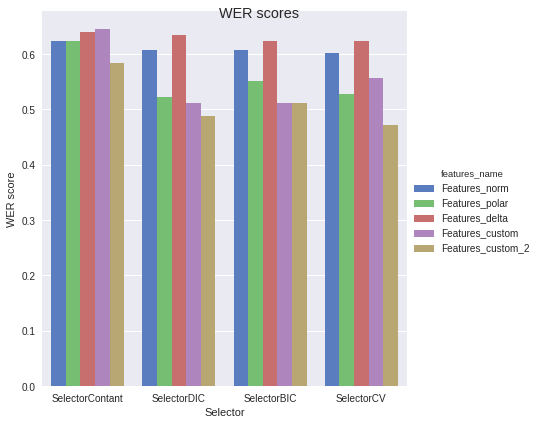

In [34]:
g = sns.factorplot(x="selector_name", y="score", hue="features_name", data=result_df,
                   size=6, kind="bar", palette="muted")

g.fig.suptitle('WER scores')
g.set(xlabel='Selector', ylabel='WER score')

plt.show()

Time taken by each of the combinations (selector, feature_set)

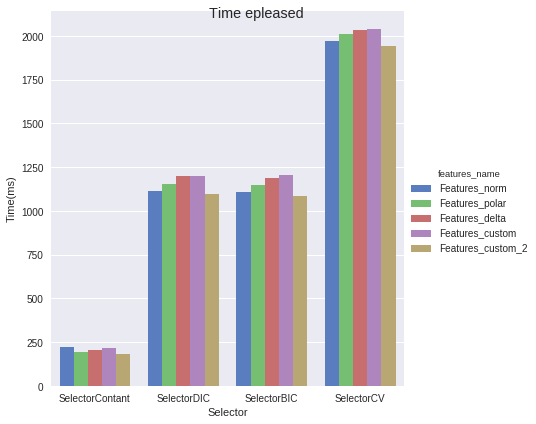

In [35]:
g = sns.factorplot(x="selector_name", y="epleased_time", hue="features_name", data=result_df,
                   size=6, kind="bar", palette="muted")

g.fig.suptitle('Time epleased')
g.set(xlabel='Selector', ylabel='Time(ms)')

plt.show()

Two charts representing the average score by features_set and by selector

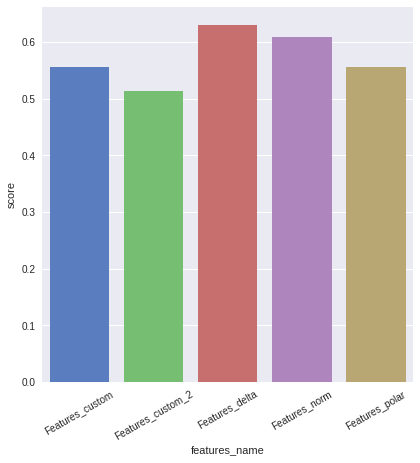

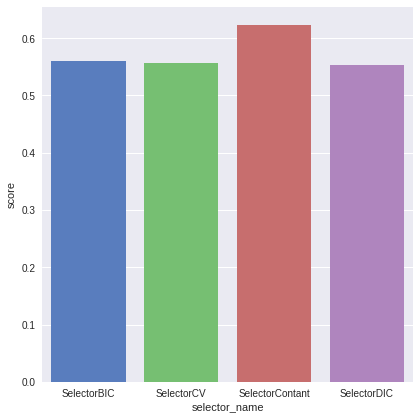

In [36]:
features_means = pd.DataFrame(result_df.groupby(['features_name'])['score'].mean()).reset_index()
selector_means = pd.DataFrame(result_df.groupby(['selector_name'])['score'].mean()).reset_index()


g = sns.factorplot(x="features_name", y="score", data=features_means,
                   size=6, kind="bar", palette="muted")

g.set_xticklabels(rotation=30)

sns.factorplot(x="selector_name", y="score", data=selector_means,
                   size=6, kind="bar", palette="muted")

plt.show()

**Question 3:**  Summarize the error results from three combinations of features and model selectors.  What was the "best" combination and why?  What additional information might we use to improve our WER?  For more insight on improving WER, take a look at the introduction to Part 4.

**Answer 3:**
The best WER score was 0.471910 which was achieved by the CV Selector using custom_features_2. This could be because the custom_features_2 include more information that the other feature_sets.

If time is an issue, then  DIC selector would be the best choice since it took half of the time with similares results.

WER can be improved in the following ways:
    - N-Grams: Because some words are more likely to appear together, n-grams model uses a group of
    words instead of a single word. Furthermore, there are cases in which we wouldn't be able to predict
    the correct word without taking in account the context, so is the case of the homophones which are
    words that are pronounced the same but have different spelling such as allowed, aloud.
    

<a id='part3_test'></a>
### Recognizer Unit Tests
Run the following unit tests as a sanity check on the defined recognizer.  The test simply looks for some valid values but is not exhaustive. However, the project should not be submitted if these tests don't pass.

In [37]:
import unittest
from asl_test_recognizer import TestRecognize

suite = unittest.TestLoader().loadTestsFromModule(TestRecognize())
unittest.TextTestRunner().run(suite)

..
----------------------------------------------------------------------
Ran 2 tests in 29.527s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

<a id='part4_info'></a>
## PART 4: (OPTIONAL)  Improve the WER with Language Models
We've squeezed just about as much as we can out of the model and still only get about 50% of the words right! Surely we can do better than that.  Probability to the rescue again in the form of [statistical language models (SLM)](https://en.wikipedia.org/wiki/Language_model).  The basic idea is that each word has some probability of occurrence within the set, and some probability that it is adjacent to specific other words. We can use that additional information to make better choices.

##### Additional reading and resources
- [Introduction to N-grams (Stanford Jurafsky slides)](https://web.stanford.edu/class/cs124/lec/languagemodeling.pdf)
- [Speech Recognition Techniques for a Sign Language Recognition System, Philippe Dreuw et al](https://www-i6.informatik.rwth-aachen.de/publications/download/154/Dreuw--2007.pdf) see the improved results of applying LM on *this* data!
- [SLM data for *this* ASL dataset](ftp://wasserstoff.informatik.rwth-aachen.de/pub/rwth-boston-104/lm/)

##### Optional challenge
The recognizer you implemented in Part 3 is equivalent to a "0-gram" SLM.  Improve the WER with the SLM data provided with the data set in the link above using "1-gram", "2-gram", and/or "3-gram" statistics. The `probabilities` data you've already calculated will be useful and can be turned into a pandas DataFrame if desired (see next cell).  
Good luck!  Share your results with the class!

In [53]:
# create a DataFrame of log likelihoods for the test word items
probabilities = result_df.sort_values(['score'], ascending=True).head(1)['recognize_probabilities'].values[0]
df_probs = pd.DataFrame(data=probabilities)
df_probs.head()

,ALL,ANN,APPLE,ARRIVE,BILL,BLAME,BLUE,BOOK,BORROW,BOX,...,VIDEOTAPE,VISIT,WANT,WHAT,WHO,WILL,WOMAN,WONT,WRITE,YESTERDAY
0,-10581.199297,-3.516402e+04,-1803.226240,-434.609240,-3164.769955,-268.709465,-8.798882e+04,-1369.510158,-2115.796617,-911.358978,...,-2527.922411,-164.960090,-10547.980942,-368.340175,-277.189153,-1175.338733,-396.025044,-789.435297,-190.503571,-399.809887
1,-30646.571209,-1.855753e+06,-6681.221434,-131.395042,-4147.930911,-546.878748,-1.092475e+06,-164.333815,-927.573543,-1396.860567,...,-372.209240,-441.211846,-7523.547765,-241.883826,-985.142537,-10193.642172,-648.367186,-6522.456641,-65.423877,-1204.967069
2,-43713.577229,-2.390438e+06,-8961.754313,-417.355231,-7543.862640,-776.504884,-8.151699e+05,-1230.709588,-1193.624631,-3096.554645,...,-1347.419930,-862.680443,-8637.648606,-794.109312,-960.375898,-11561.945736,-968.339531,-5491.179933,-276.896048,-1799.564781
3,-2829.994501,-1.274581e+06,-396.225600,-439.369645,-1078.589505,-455.737367,-3.094392e+03,-4827.469355,-10962.978690,-762.977072,...,-7148.035704,-146.643654,-125414.250146,-737.890241,-334.690224,-2040.351686,-311.555125,-4688.458769,-848.754231,-273.703226
4,-5342.500976,-1.231658e+04,-938.979034,-104.280774,-1776.346511,-73.811126,-6.696715e+04,-340.647195,-774.741993,-126.803644,...,-1059.714569,-48.914462,-1893.953859,-51.737425,-710.189020,-1306.751182,-142.255418,-1030.951116,-290.455468,-168.870982
